*Check the gradient boosting algorithm in section 10.10.2 of the book, [Elements of Statistical Learning](https://hastie.su.domains/ElemStatLearn/) before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

## Hyperparameters
There are 5 important parameters to tune in Gradient boosting:

1. Number of trees 

2. Depth of each tree 

3. Learning rate  

4. Subsample fraction

5. Maximum features

Let us visualize the accuracy of Gradient boosting when we independently tweak each of the above parameters.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings
from IPython import display

In [2]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

carID brand      model  year transmission  mileage fuelType  tax      mpg  \
0  18473   bmw   6 Series  2020    Semi-Auto       11   Diesel  145  53.3282   
1  15064   bmw   6 Series  2019    Semi-Auto    10813   Diesel  145  53.0430   
2  18268   bmw   6 Series  2020    Semi-Auto        6   Diesel  145  53.4379   
3  18480   bmw   6 Series  2017    Semi-Auto    18895   Diesel  145  51.5140   
4  18492   bmw   6 Series  2015    Automatic    62953   Diesel  160  51.4903   

   engineSize  price  
0         3.0  37980  
1         3.0  33980  
2         3.0  36850  
3         3.0  25998  
4         3.0  18990

In [3]:
X = train[['mileage','mpg','year','engineSize']]
Xtest = test[['mileage','mpg','year','engineSize']]
y = train['price']
ytest = test['price']

## Gradient boosting for regression

### Number of trees vs cross validation error
As per the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor), Gradient boosting is fairly robust to over-fitting (why?) so a large number usually results in better performance.

>2 14927.566 (179.475)
>5 12743.148 (189.408)
>10 10704.199 (226.234)
>50 6869.066 (278.885)
>100 6354.656 (270.097)
>500 5515.622 (424.516)
>1000 5515.251 (427.767)
>2000 5600.041 (389.687)
>5000 5854.168 (362.223)


Text(0.5, 0, 'Number of trees')

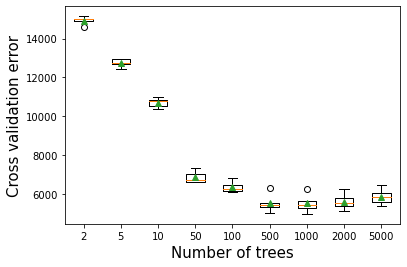

In [37]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [2, 5, 10, 50, 100, 500, 1000, 2000, 5000]
    for n in n_trees:
        models[str(n)] = GradientBoostingRegressor(n_estimators=n,random_state=1,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

### Depth of tree vs cross validation error
As the depth of each weak learner (decision tree) increases, the complexity of the weak learner will increase. As the complexity increases, the prediction bias will decrease, while the prediction variance will increase. Thus, there will be an optimal depth of each weak learner that minimizes the prediction error.

>1 9693.731 (810.090)
>2 7682.569 (489.841)
>3 6844.225 (536.792)
>4 5972.203 (538.693)
>5 5664.563 (497.882)
>6 5329.130 (404.330)
>7 5210.934 (461.038)
>8 5197.204 (494.957)
>9 5227.975 (478.789)
>10 5299.782 (446.509)
>11 5433.822 (451.673)
>12 5617.946 (509.797)
>13 5876.424 (542.981)
>14 6030.507 (560.447)
>15 6125.914 (643.852)
>16 6294.784 (672.646)
>17 6342.327 (677.050)
>18 6372.418 (791.068)
>19 6456.471 (741.693)
>20 6503.622 (759.193)


Text(0.5, 0, 'Depth of each tree')

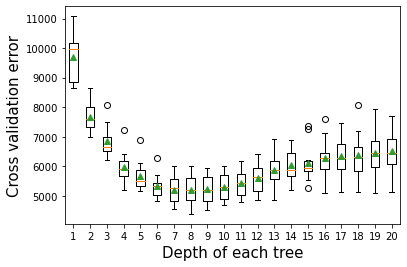

In [36]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = GradientBoostingRegressor(n_estimators=50,random_state=1,max_depth=i,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

### Learning rate vs cross validation error
The optimal learning rate will depend on the number of trees, and vice-versa. If the learning rate is too low, it will take several trees to "learn" the response. If the learning rate is high, the response will be "learned" quickly (with fewer) trees.  Learning too quickly will be prone to overfitting, while learning too slowly will be computationally expensive. Thus, there will be an optimal learning rate to minimize the prediction error.

>0.1 6329.8 (450.7)
>0.2 5942.9 (454.8)
>0.3 5618.4 (490.8)
>0.4 5665.9 (577.3)
>0.5 5783.5 (561.7)
>0.6 5773.8 (500.3)
>0.7 5875.5 (565.7)
>0.8 5878.5 (540.5)
>0.9 6214.4 (594.3)
>1.0 5986.1 (601.5)
>1.1 6216.5 (395.3)
>1.2 6667.5 (657.2)
>1.3 6717.4 (594.4)
>1.4 7048.4 (531.7)
>1.5 7265.0 (742.0)
>1.6 7404.4 (868.2)
>1.7 7425.8 (606.3)
>1.8 8283.0 (1345.3)
>1.9 8872.2 (1137.9)
>2.0 17713.3 (865.3)


Text(0.5, 0, 'Learning rate')

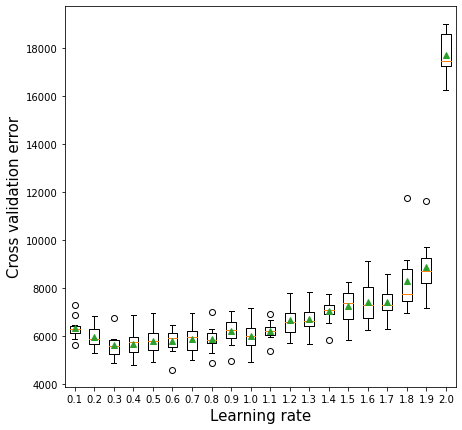

In [34]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = GradientBoostingRegressor(learning_rate=i,random_state=1,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.1f (%.1f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

### Subsampling vs cross validation error

>0.25 6219.59 (569.97)
>0.50 6178.28 (501.87)
>0.75 6141.96 (432.66)
>1.00 6329.79 (450.72)


Text(0.5, 0, 'Subsample')

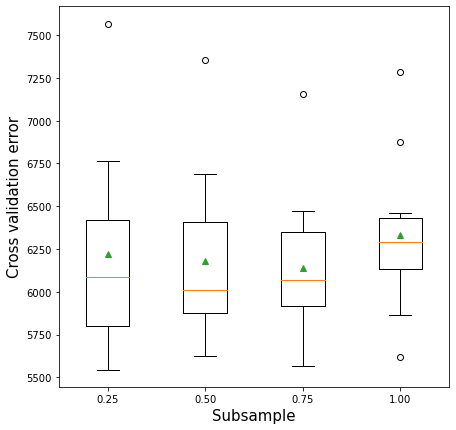

In [5]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for s in np.arange(0.25, 1.1, 0.25):
        key = '%.2f' % s
        models[key] = GradientBoostingRegressor(random_state=1,subsample=s,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.2f (%.2f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Subsample',fontsize=15)

### Maximum features vs cross-validation error

>0.25 6654.27 (567.72)
>0.50 6373.92 (538.53)
>0.75 6325.55 (470.41)
>1.00 6329.79 (450.72)


Text(0.5, 0, 'Maximum features')

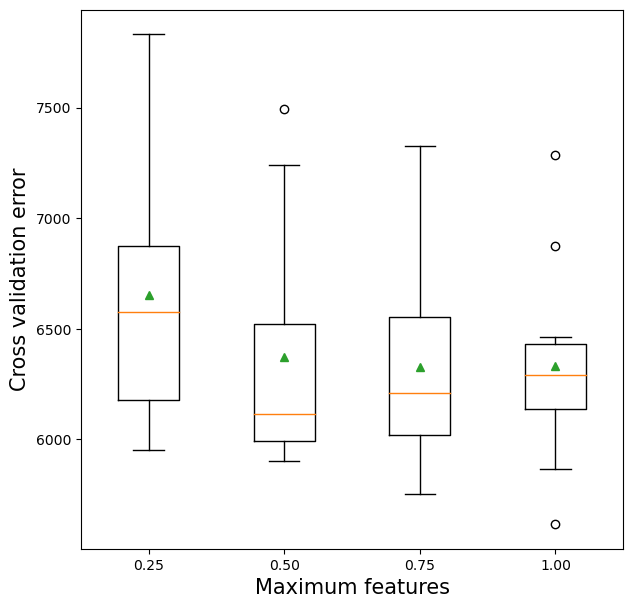

In [5]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for s in np.arange(0.25, 1.1, 0.25):
        key = '%.2f' % s
        models[key] = GradientBoostingRegressor(random_state=1,max_features=s,loss='huber')
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1))
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.2f (%.2f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Maximum features',fontsize=15)

### Tuning Gradient boosting for regression
As the optimal value of the parameters depend on each other, we need to optimize them simultaneously.

In [69]:
start_time = time.time()
model = GradientBoostingRegressor(random_state=1,loss='huber')
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [3,5,8,10,12,15]

# define the evaluation procedure
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error',
                          verbose = True)
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (np.sqrt(-grid_result.best_score_), grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param)
print("Time taken = ",(time.time()-start_time)/60," minutes")

Best: 5190.765919 using {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100}
Time taken =  46.925597019990285  minutes


Note that the code takes 46 minutes to run. In case of a lot of hyperparameters, [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) may be preferred to trade-off between optimality of the solution and computational cost.

['learning_rate', 'max_features', 'max_leaf_nodes', 'n_estimators', 'subsample'] = [0.23102084158310995, 0.315075948850183, 5000, 817, 1.0] 5360.92726695485
Time so far =  21.0 minutes


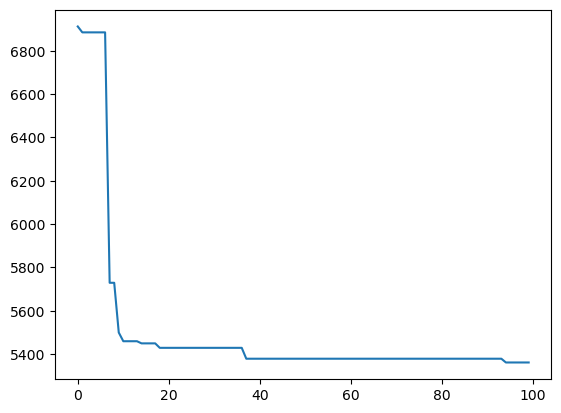

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
              estimator=GradientBoostingRegressor(loss='huber', random_state=1),
              n_iter=100, n_jobs=-1, random_state=1,
              scoring='neg_root_mean_squared_error',
              search_spaces={'learning_rate': Real(low=0.0001, high=1.0, prior='uniform', transform='normalize'),
                             'max_features': Real(low=0.1, high=1, prior='uniform', transform='normalize'),
                             'max_leaf_nodes': Integer(low=4, high=5000, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=2, high=1000, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.1, high=1, prior='uniform', transform='normalize')})

In [14]:
model = GradientBoostingRegressor(random_state=1, loss='huber') 
grid = dict()
grid['n_estimators'] = Integer(2, 1000)
grid['learning_rate'] = Real(0.0001, 1.0)
grid['max_leaf_nodes'] = Integer(4, 5000)
grid['subsample'] = Real(0.1, 1)
grid['max_features'] = Real(0.1, 1)

kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)
gcv = BayesSearchCV(model, search_spaces = grid, cv = kfold, n_iter = 100, random_state = 1,
                         scoring = 'neg_root_mean_squared_error', n_jobs = -1)
paras = list(gcv.search_spaces.keys())
paras.sort()
start_time = time.time()
def monitor(optim_result):
    cv_values = pd.Series(optim_result['func_vals']).cummin()
    display.clear_output(wait = True)
    min_ind = pd.Series(optim_result['func_vals']).argmin()
    print(paras, "=", optim_result['x_iters'][min_ind], pd.Series(optim_result['func_vals']).min())
    print("Time so far = ", np.round((time.time()-start_time)/60), "minutes")
    sns.lineplot(cv_values)
    plt.show()
gcv.fit(X, y, callback = monitor)

In [17]:
#Model based on the optimal parameters
model = GradientBoostingRegressor(max_depth=8,n_estimators=100,learning_rate=0.1,
                         random_state=1,loss='huber').fit(X,y)

In [18]:
#RMSE of the optimized model on test data
print("Gradient boost RMSE = ",np.sqrt(mean_squared_error(model.predict(Xtest),ytest)))

Gradient boost RMSE =  5405.787029062213


In [15]:
#Model based on the optimal parameters
model_bayes = GradientBoostingRegressor(max_leaf_nodes=5000,n_estimators=817,learning_rate=0.23, max_features=0.31,
                         random_state=1,subsample=1.0,loss='huber').fit(X,y)

In [16]:
#RMSE of the optimized model on test data
print("Gradient boost RMSE = ",np.sqrt(mean_squared_error(model_bayes.predict(Xtest),ytest)))

Gradient boost RMSE =  5734.200307094321


In [19]:
#Let us combine the Gradient boost model with other models
model2 = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10),n_estimators=50,learning_rate=1.0,
                         random_state=1).fit(X,y)
print("AdaBoost RMSE = ",np.sqrt(mean_squared_error(model2.predict(Xtest),ytest)))
model3 = RandomForestRegressor(n_estimators=300, random_state=1,
                        n_jobs=-1, max_features=2).fit(X, y)
print("Random Forest RMSE = ",np.sqrt(mean_squared_error(model3.predict(Xtest),ytest)))


AdaBoost RMSE =  5693.165811600585
Random Forest RMSE =  5642.45839697972


In [20]:
#Ensemble model
pred1=model.predict(Xtest)#Gradient boost
pred2=model2.predict(Xtest)#Adaboost
pred3=model3.predict(Xtest)#Random forest
pred = 0.34*pred1+0.33*pred2+0.33*pred3 #Higher weight to the better model
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(pred,ytest)))

Ensemble model RMSE =  5364.478227748279


### Ensemble modeling (for regression models)

In [68]:
#Ensemble model
pred1=model.predict(Xtest)#Gradient boost
pred2=model2.predict(Xtest)#Adaboost
pred3=model3.predict(Xtest)#Random forest
pred = 0.6*pred1+0.2*pred2+0.2*pred3 #Higher weight to the better model
print("Ensemble model RMSE = ", np.sqrt(mean_squared_error(pred,ytest)))

Ensemble model RMSE =  5323.119083375402


Combined, the random forest model, gradient boost and the Adaboost model do better than each of the individual models.

Note that ideally we should do K-fold cross validation to figure out the optimal weights. We'll learn about ensembling techniques later in the course.

## Gradient boosting for classification
Below is the Gradient boost implementation on a classification problem. The takeaways are the same as that of the regression problem above.

In [9]:
train = pd.read_csv('./Datasets/diabetes_train.csv')
test = pd.read_csv('./Datasets/diabetes_test.csv')

In [10]:
X = train.drop(columns = 'Outcome')
Xtest = test.drop(columns = 'Outcome')
y = train['Outcome']
ytest = test['Outcome']

### Number of trees vs cross validation accuracy

>10 0.738 (0.031)
>50 0.748 (0.054)
>100 0.722 (0.075)
>500 0.707 (0.066)
>1000 0.712 (0.075)
>5000 0.697 (0.061)


Text(0.5, 0, 'Number of trees')

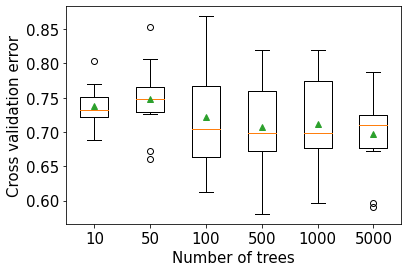

In [48]:
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100, 500, 1000, 5000]
    for n in n_trees:
        models[str(n)] = GradientBoostingClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

### Depth of each tree vs cross validation accuracy

>1 0.746 (0.040)
>2 0.744 (0.046)
>3 0.722 (0.075)
>4 0.743 (0.049)
>5 0.738 (0.046)
>6 0.741 (0.047)
>7 0.735 (0.057)
>8 0.736 (0.051)
>9 0.728 (0.055)
>10 0.710 (0.050)
>11 0.697 (0.061)
>12 0.681 (0.056)
>13 0.709 (0.047)
>14 0.702 (0.048)
>15 0.705 (0.048)
>16 0.700 (0.042)
>17 0.699 (0.048)
>18 0.697 (0.050)
>19 0.696 (0.042)
>20 0.697 (0.048)


Text(0.5, 0, 'Depth of each tree')

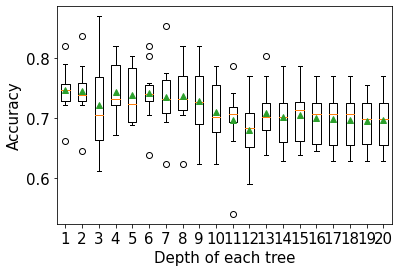

In [50]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define ensemble model
        models[str(i)] = GradientBoostingClassifier(random_state=1,max_depth=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

### Learning rate vs cross validation accuracy

>0.1 0.747 (0.044)
>0.2 0.736 (0.028)
>0.3 0.726 (0.039)
>0.4 0.730 (0.034)
>0.5 0.726 (0.041)
>0.6 0.722 (0.043)
>0.7 0.717 (0.050)
>0.8 0.713 (0.033)
>0.9 0.694 (0.045)
>1.0 0.695 (0.032)
>1.1 0.718 (0.034)
>1.2 0.692 (0.045)
>1.3 0.708 (0.042)
>1.4 0.704 (0.050)
>1.5 0.702 (0.028)
>1.6 0.700 (0.050)
>1.7 0.694 (0.044)
>1.8 0.650 (0.075)
>1.9 0.551 (0.163)
>2.0 0.484 (0.123)


Text(0.5, 0, 'Learning rate')

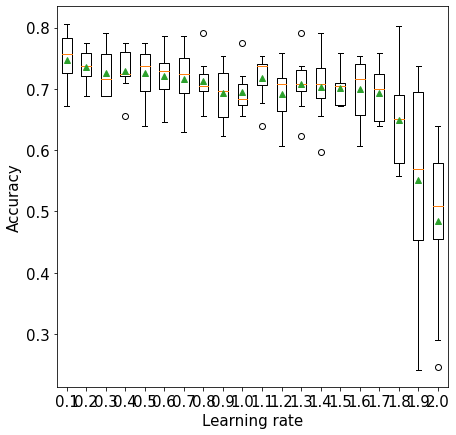

In [51]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = GradientBoostingClassifier(learning_rate=i,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

### Tuning Gradient boosting Classifier

In [17]:
start_time = time.time()
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [1,2,3,4,5]
grid['subsample'] = [0.5,1.0]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose = True, scoring = 'recall')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Time taken = ", time.time() - start_time, "seconds")

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best: 0.701045 using {'learning_rate': 1.0, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.5}
Time taken =  32.46394085884094


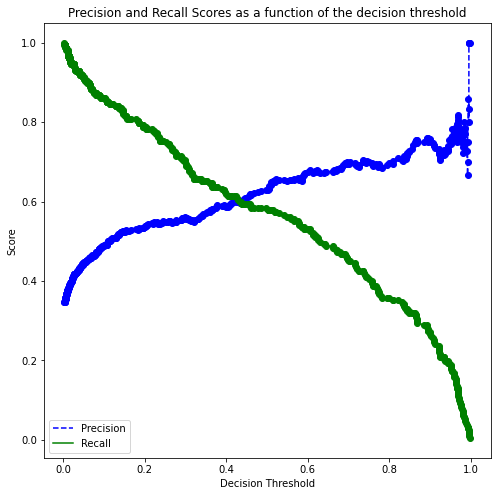

In [18]:
#Model based on the optimal parameters
model = GradientBoostingClassifier(random_state=1,max_depth=3,learning_rate=0.1,subsample=0.5,
                          n_estimators=200).fit(X,y)

# Note that we are using the cross-validated predicted probabilities, instead of directly using the 
# predicted probabilities on train data, as the model may be overfitting on the train data, and 
# may lead to misleading results
cross_val_ypred = cross_val_predict(GradientBoostingClassifier(random_state=1,max_depth=3,
                                                               learning_rate=0.1,subsample=0.5,
                          n_estimators=200), X, y, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y, cross_val_ypred[:,1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [19]:
# Thresholds with precision and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_80 = all_thresholds[all_thresholds[:,2]>0.8,:]
# As the values in 'recall_more_than_80' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_80[recall_more_than_80.shape[0]-1]

array([0.18497144, 0.53205128, 0.80193237])

In [20]:
#Optimal decision threshold probability
thres = recall_more_than_80[recall_more_than_80.shape[0]-1][0]
thres

0.18497143500912738

Accuracy:  77.92207792207793
ROC-AUC:  0.8704389212057112
Precision:  0.6626506024096386
Recall:  0.9016393442622951


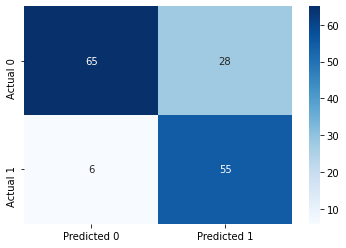

In [21]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob = model.predict_proba(Xtest)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, ytest)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(ytest, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(ytest, y_pred))
print("Recall: ", recall_score(ytest, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(ytest, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

The model seems to be similar to the Adaboost model. However, gradient boosting algorithms with robust loss functions can perform better than Adaboost in the presence of outliers *(in terms of response)* in the data.

## Faster algorithms and tuning tips

Check out [`HistGradientBoostingRegressor()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) and [`HistGradientBoostingClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) for a faster gradient boosting algorithm for big datasets *(more than 10,000 observations)*.

Check out tips for faster hyperparameter tuning, such as tuning `max_leaf_nodes` instead of `max_depth` [here](https://scikit-learn.org/stable/modules/ensemble.html#controlling-the-tree-size).